## **Surface Crack Detection using Quantum-classical Neural Networks with PyTorch and Qiskit**



CNN is a type of neural network which uses a special operation called convolution and works best on image dataset.<br>

There are a lot of preprocessing methods that can be used in this pipeline.

Convolution is a multiplication operation between an input and a filter. It's not a simple multiplication process, rather, it is computed by multiplying the input with the filter over a delayed period of time.

**Input * filter -> Answer**

As more and more ideas based on Hybrid Learning Environment come up with combining classical and quantum world to solve various problems. <br>Here is one approach that uses a machine learning framework, PyTorch to create a Hybrid Learning Environment.<br> With this Hybrid approach, a system can be created  with classical neural network, but with some of the nodes replaced with quantum circuit. 


**Implementation:**

>Step 0 : Installing & Importing Required Python Modules <br>step 1 : Load the image dataset.<br> step 2 : Preprocessing the image dataset.<br> step 3 : Then we define the model architecture and add a custom layer for training our model.<br> step 4 : Train model for 20 epochs.<br> step 5 : Train model to make inference of our test dataset.<br> step 6 : Visualize the results of our data

##**Installing Required Modules**

In [ ]:
!pip install qiskit 
!pip install qiskit-aer-gpu
!pip install qiskit_machine_learning
!pip install torch
!pip install torchvision
!pip install kaggle

##**Importing Modules**

In [ ]:
## If local dataset is not available
# ! mkdir ~/.kaggle                           # Make directory named kaggle
# ! cp kaggle.json ~/.kaggle/                 # Copy kaggle.json file there
# ! chmod 600 ~/.kaggle/kaggle.json           # Change the permissions of the file.

In [ ]:
# Importing Required Python Modules
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#Importing Pytorch Specific Modules
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, transforms,models
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
from sklearn.model_selection import KFold

#Importing Qiskit Specific Modules
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
## If local dataset is not available then uncomment below line
#import kaggle

#**Checking for GPU Availability**

In [ ]:
simulator = qiskit.Aer.get_backend('aer_simulator')

use_cuda = torch.cuda.is_available()

print('CUDA available:', use_cuda)

if use_cuda:
    device = torch.device('cuda')
    print('Training on GPU...')
    simulator.set_options(device='GPU')
else:
    device = torch.device('cpu')
    print('Training on CPU...')

CUDA available: False
Training on CPU...


## **Step 1: Load the Dataset and Visualize it**
* Link to the cracks data set:  https://www.kaggle.com/arunrk7/surface-crack-detection/metadata


In [ ]:
!kaggle datasets download -d arunrk7/surface-crack-detection     # Downloading the zip file using Kaggle Credentials

surface-crack-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip surface-crack-detection.zip                            # Unzip the data
from IPython.display import clear_output
clear_output()

In [ ]:
crack_images = os.listdir('Positive/')
print("Number of Crack Images: ", len(crack_images))

Number of Crack Images:  20000


In [ ]:
no_crack_images = os.listdir('Negative/')
print("Number of No Crack Images: ", len(no_crack_images))

Number of No Crack Images:  20000


Visualize Random images with cracks

*****************Random Images with Cracks**************************


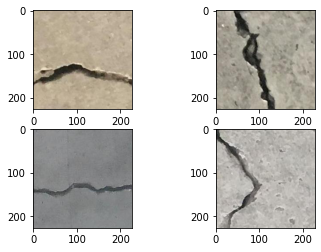

In [ ]:
random_indices = np.random.randint(0, len(crack_images), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[3])))

Visualize Random images with no cracks

*****************Random Images without Cracks**************************


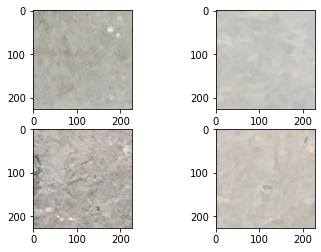

In [ ]:
random_indices = np.random.randint(0, len(no_crack_images), size=4)
print("*****************Random Images without Cracks**************************")
random_images = np.array(no_crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[3])))

## **Create Train and Val Data sets**

### Create training folder

In [ ]:
!rm -rf train
base_dir = cwd
files = os.listdir(base_dir)

In [ ]:
##Considering only 1000 images from each class in order to restrict Compute resource utilization
def create_training_data(folder_name):
    files_list = os.listdir(os.path.join(base_dir,folder_name))
    files_list = files_list[0:1000]
    train_dir = f"{base_dir}/train/{folder_name}"
    os.makedirs(train_dir)
    for f in files:
          search_object = re.search(folder_name, f)
          if search_object:
            for file_name in files_list:
              shutil.copy(f'{base_dir}/{folder_name}/{file_name}', train_dir)

In [ ]:
create_training_data('Positive')
create_training_data('Negative')
!rm -rf val

### Move images randomly from training to val folders

In [ ]:
os.makedirs('val/Positive')
os.makedirs('val/Negative')

In [ ]:
positive_train = base_dir + "/train/Positive/"
positive_val = base_dir + "/val/Positive/"
negative_train = base_dir + "/train/Negative/"
negative_val = base_dir + "/val/Negative/"

positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)

In [ ]:
print(len(positive_files), len(negative_files))             # Checking for the total count of file to be unchanged. Expected output: 20000 20000

1000 1000


In [ ]:
for f in positive_files:
    if random.random() > 0.80:
        shutil.move(f'{positive_train}/{f}', positive_val)   # moving files to positivr_val

In [ ]:
for f in negative_files:
    if random.random() > 0.80:
        shutil.move(f'{negative_train}/{f}', negative_val)   # moving files to negative_val

## **Step 2: Preprocessing the Image Dataset**
## Pytorch data loader and Transforms

### Compute mean and std deviation for the dataset

There are 3 channels in a RGB IMAGE.
> 1. Red
2. Green
3. Blue

In [ ]:
mean_nums = [0.5, 0.5, 0.5]
std_nums = [0.5, 0.5, 0.5]

### Define Data Augmentation and Transforms

In [ ]:
import torchvision.transforms

In [ ]:
data_path_train = os.path.join(cwd, 'train')
data_path_test = os.path.join(cwd, 'val')
chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

### Create the Data Loader

In [ ]:
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=2,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [ ]:
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  1578
Class Names are:  ['Negative', 'Positive']
torch.Size([8, 3, 227, 227]) torch.Size([8])


In [ ]:
test_loader, test_size, class_names = load_dataset('val', 8)
print("Test Data Set size is: ", test_size)
print("Class Names are: ", class_names)
inputs_test, classes_test = next(iter(test_loader))
print(inputs_test.shape, classes_test.shape)

Test Data Set size is:  422
Class Names are:  ['Negative', 'Positive']
torch.Size([8, 3, 227, 227]) torch.Size([8])


### Visualize the Augmented Data Set

In [ ]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

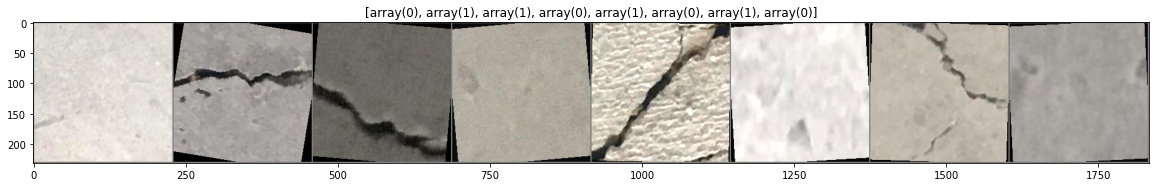

In [ ]:
# Grab some of the training data to visualize
inputs, classes = next(iter(train_loader))         # class_names = chosen_datasets['train'].classes

out = torchvision.utils.make_grid(inputs)          # Now we construct a grid from batch

idx_to_class = {0:'Negative', 1:'Positive'}
plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

## **Step 3: Define the architecture to train the model**



##Define Quantum Circuit and Layer

In [ ]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result_circ = job.result().get_counts()
        y = list(map(int, result_circ.values()))
        # counts = np.array(list(result_circ.values()))
        counts= np.array(y)
        states = np.array(list(result_circ.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

Let's test the implementation

In [ ]:
circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Expected value for rotation pi 0.43


┌───┐ ░ ┌───────────┐ ░ ┌─┐
   q_0: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

### Creating a "Quantum-Classical Class" with PyTorch <a id='qc-class'></a>


In [ ]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for input in inputs:
            expectation_z.append(ctx.quantum_circuit.run(input.tolist()))
        result = torch.tensor(expectation_z).to(device)
        
        ctx.save_for_backward(inputs, result)
        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]).to(device) - torch.tensor([expectation_left]).to(device)
            gradients.append(gradient)
        
        # gradients = np.array([gradients]).T
        gradients = torch.tensor([gradients]).to(device)
        gradients = torch.transpose(gradients, 0, 1)

        # return torch.tensor([gradients]).float() * grad_output.float(), None, None
        return gradients.float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.dropout = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(1152, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
        self.hybrid = [Hybrid(simulator, 100, np.pi / 2) for i in range(2)]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 8)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 4)
        x = self.dropout(x)
        # x = x.view(-1, 256)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x=  self.fc3(x)
        x = torch.chunk(x, 10, dim=1)
        x = tuple([hy(x_) for hy, x_ in zip(self.hybrid, x)])
        return torch.cat(x, -1)

In [ ]:
# Convert model to be used on GPU
model = Net().to(device)
from torchsummary import summary
print(summary(model, (3, 227, 227)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 225, 225]             448
            Conv2d-2           [-1, 32, 26, 26]           4,640
         Dropout2d-3             [-1, 32, 6, 6]               0
            Linear-4                  [-1, 256]         295,168
            Linear-5                   [-1, 64]          16,448
            Linear-6                    [-1, 2]             130
Total params: 316,834
Trainable params: 316,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.59
Forward/backward pass size (MB): 6.36
Params size (MB): 1.21
Estimated Total Size (MB): 8.15
----------------------------------------------------------------
None


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


## **Step 4: Training our Model**


In [ ]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'Negative', 1:'Positive'}


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_list = []
    train_acc = []
    val_acc =[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                acc_hist = train_acc
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                acc_hist = val_acc
            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            # training starts...
            total_loss = []
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                # Re-setting all of model parameters

                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).to(device)
                    # this computes the class that the model belongs to...
                    _, preds = torch.max(outputs, 1)

                    # compute the loss here...
                    # we compute the difference between true label and the predicted output...
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # this is the back-propragation step. we 
                        
                        # minimize our model loss and optimize model in this phase
                        optimizer.step()
                        # optimizer updates the model paramters...
                        

                # We want variables to hold the loss statistics
                # combine our model losses and compute the wrongly classified examples
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                total_loss.append(loss.item())
    
            # compute the loss and accuracy for each of our epoch
            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]
            acc_hist.append(epoch_acc)
            loss_list.append(sum(total_loss)/len(total_loss))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    #Plotting the training graph
    plt.figure(figsize = (15,10))
    plt.plot(loss_list)
    plt.title('Convolutional NN Training Convergence')
    plt.xlabel('Training Iterations')
    plt.ylabel('Neg Log Likelihood Loss')
    plt.show()

    #Plotting the learning curve - Accuracy
    plt.figure(figsize = (15,10))
    plt.title('Training Vs Validation Accuracy')
    plt.plot(train_acc, label='train_accuracy')
    plt.plot(val_acc, label='val_accuracy')
    plt.legend(loc='best')
    plt.show()
    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).to(device)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

###**Define Optimizer and Loss Function**<br>
Learning rate decay- As we train the model, we can decide to change the learning rate dynamically. The schedular helps us in doing that. <br>
In the 1st epoch, the learning rate was 0.1, then the learning rate in epoch 4 would be 0.01. 

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

### **Start training**

Epoch 0/19
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


train Loss: 0.6642 Acc: 0.6084
Iterating through data...
val Loss: 0.5029 Acc: 0.9242

Epoch 1/19
----------
Iterating through data...
train Loss: 0.5492 Acc: 0.7674
Iterating through data...
val Loss: 0.4139 Acc: 0.9171

Epoch 2/19
----------
Iterating through data...
train Loss: 0.5171 Acc: 0.8105
Iterating through data...
val Loss: 0.4106 Acc: 0.9313

Epoch 3/19
----------
Iterating through data...
train Loss: 0.5113 Acc: 0.8181
Iterating through data...
val Loss: 0.4131 Acc: 0.9360

Epoch 4/19
----------
Iterating through data...
train Loss: 0.4878 Acc: 0.8568
Iterating through data...
val Loss: 0.4146 Acc: 0.9408

Epoch 5/19
----------
Iterating through data...
train Loss: 0.4918 Acc: 0.8536
Iterating through data...
val Loss: 0.4143 Acc: 0.9431

Epoch 6/19
----------
Iterating through data...
train Loss: 0.4971 Acc: 0.8416
Iterating through data...
val Loss: 0.4124 Acc: 0.9408

Epoch 7/19
----------
Iterating through data...
train Loss: 0.4850 Acc: 0.8599
Iterating through data..

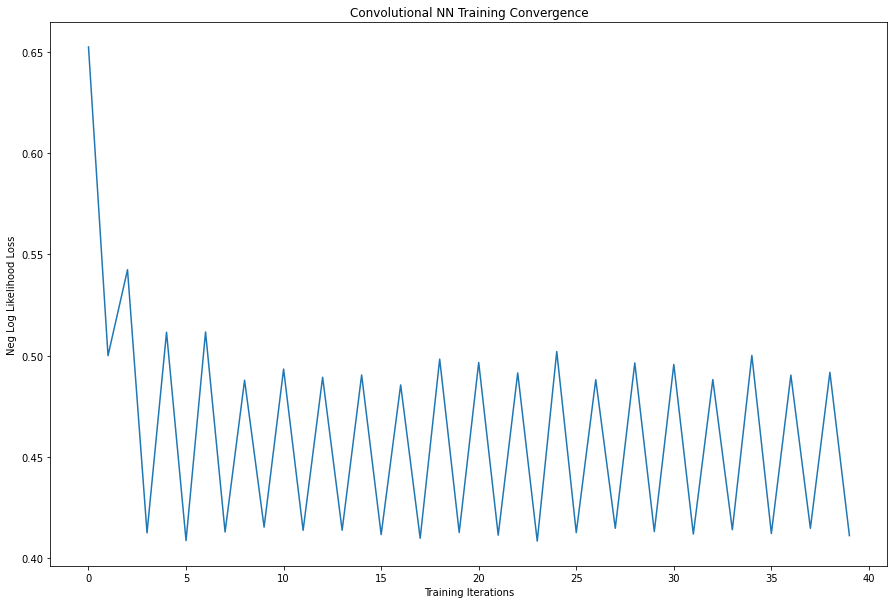

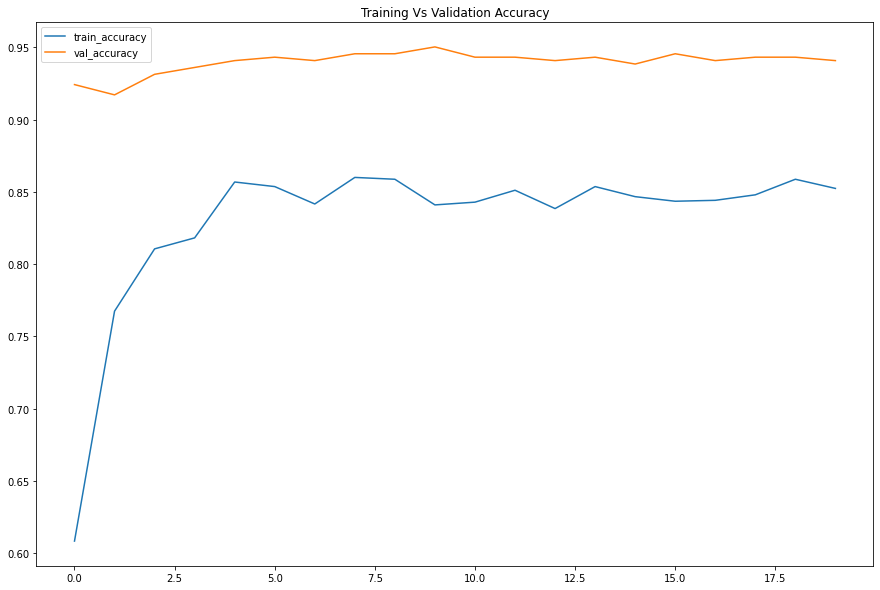

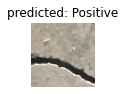

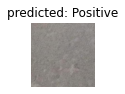

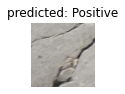

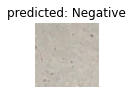

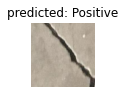

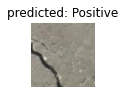

In [ ]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)
visualize_model(base_model)
plt.show()
# # an epoch is the total time during which one training step completes. In other words, it is the total
# # time that our model takes to process the input data once...

## **Step 5: Using trained model to make inference of our test dataset**

In [ ]:
def predict(model, test_image, print_class = False):
     # it uses the model to predict on test_image...
    transform = chosen_transforms['val']
     
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available(): # checks if we have a gpu available
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).to(device)
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        # this computes the output of the model
        out = model(test_image_tensor).to(device)
        # this computes the probability of each classes.
        ps = torch.exp(out)
        # we choose the top class. That is, the class with highest probability
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [ ]:
def predict_on_crops(input_image, height=32, width=32, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            ## discard image cropss that are not full size
            predicted_class = predict(base_model,Image.fromarray(a))
            ## save image
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            ## Put predicted class on the image
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            ## Save crops
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    ## Save output image
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

In [ ]:
# Specify a path
PATH = "qnn_state_dict_model.pt"

# Save
torch.save(base_model.state_dict(), PATH)
# torch.save(model.state_dict(), PATH)

## **Step 6:  Visualize the results of our data**

/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


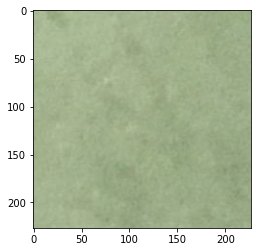

In [ ]:
plt.figure()
output_image = predict_on_crops('/content/val/Negative/00097.jpg')
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


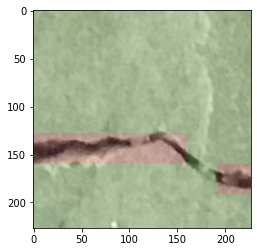

In [ ]:
plt.figure()
output_image = predict_on_crops('/content/train/Positive/00043.jpg')
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


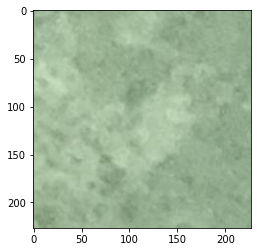

In [ ]:
plt.figure()
output_image = predict_on_crops('/content/val/Negative/01773.jpg')
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))